In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

In [7]:
# Constants
risk_free_return = 0.07  # Debt Fund Yield
start_date = '2000-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')
num_simulations = 10000
initial_investment = 1000000

In [11]:
# Read portfolio holdings
portfolio_file = "PersonalHoldings.csv"
portfolio_df = pd.read_csv(portfolio_file)
portfolio_df['SYMBOL'] = portfolio_df['SYMBOL'] + '.NS'

In [12]:
# Function to get historical stock data
def get_stock_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Adj Close']
    return data

In [19]:
# Get historical stock data
tickers = portfolio_df['SYMBOL'].tolist()
try:
    stock_prices = get_stock_data(tickers, start_date, end_date)
    print(stock_prices)
except Exception as e:
    print(e)

# Calculate daily returns
log_ret = np.log(stock_prices / stock_prices.shift(1)).dropna()

# Calculate mean daily returns and covariance matrix
mean_ret = log_ret.mean()
cov_mat = log_ret.cov() * 252

[*********************100%%**********************]  63 of 63 completed

1 Failed download:
['BLIL.NS']: Exception('%ticker%: No timezone found, symbol may be delisted')


Ticker      AARTIIND.NS  ADVENZYMES.NS  ALLCARGO.NS     ATL.NS      BEL.NS  \
Date                                                                         
2000-01-03          NaN            NaN          NaN        NaN         NaN   
2000-01-04          NaN            NaN          NaN        NaN         NaN   
2000-01-05          NaN            NaN          NaN        NaN         NaN   
2000-01-06          NaN            NaN          NaN        NaN         NaN   
2000-01-07          NaN            NaN          NaN        NaN         NaN   
...                 ...            ...          ...        ...         ...   
2024-04-05   696.450012     359.750000    77.599998  63.700001  224.500000   
2024-04-08   704.799988     365.799988    75.750000  64.099998  223.550003   
2024-04-09   699.700012     358.899994    76.000000  62.099998  228.149994   
2024-04-10   736.250000     361.149994    72.900002  61.200001  228.750000   
2024-04-12   750.950012     363.100006    72.800003  60.299999  

c:\Users\talk2\OneDrive\Desktop\UDEMY\ProjectFinanceUdemy\udemy_finance_pandas\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\talk2\OneDrive\Desktop\UDEMY\ProjectFinanceUdemy\udemy_finance_pandas\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\talk2\OneDrive\Desktop\UDEMY\ProjectFinanceUdemy\udemy_finance_pandas\lib\site-packages\pandas\core\frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\talk2\OneDrive\Desktop\UDEMY\ProjectFinanceUdemy\udemy_finance_pandas\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\talk2\OneDrive\Desktop\UDEMY\ProjectFinanceUdemy\udemy_finance_pandas\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountere

In [20]:
# Portfolio optimization
def calc_portfolio_metrics(weights, mean_ret, cov_mat, risk_free_rate):
    port_ret = np.sum(mean_ret * weights)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_mat, weights)))
    sharpe_ratio = (port_ret - risk_free_rate) / port_risk
    return port_ret, port_risk, sharpe_ratio

def neg_sharpe_ratio(weights, mean_ret, cov_mat, risk_free_rate):
    return -calc_portfolio_metrics(weights, mean_ret, cov_mat, risk_free_rate)[2]

In [21]:
# Minimum variance portfolio
weights_init = np.random.rand(len(tickers))
weights_init /= np.sum(weights_init)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(tickers)))

min_var_portfolio = minimize(neg_sharpe_ratio, weights_init,
                             args=(mean_ret, cov_mat, risk_free_return),
                             method='SLSQP', bounds=bounds, constraints=constraints)

min_var_weights = min_var_portfolio['x']
min_var_metrics = calc_portfolio_metrics(min_var_weights, mean_ret, cov_mat, risk_free_return)

# Tangency portfolio (max Sharpe ratio)
max_sr_portfolio = minimize(neg_sharpe_ratio, weights_init,
                            args=(mean_ret, cov_mat, risk_free_return),
                            method='SLSQP', bounds=bounds, constraints=constraints)

max_sr_weights = max_sr_portfolio['x']
max_sr_metrics = calc_portfolio_metrics(max_sr_weights, mean_ret, cov_mat, risk_free_return)


In [22]:
# Display results
print("Minimum Variance Portfolio:")
print("Weights:", min_var_weights)
print("Returns:", min_var_metrics[0])
print("Risk:", min_var_metrics[1])
print("Sharpe Ratio:", min_var_metrics[2])

print("\nTangency Portfolio (Max Sharpe Ratio):")
print("Weights:", max_sr_weights)
print("Returns:", max_sr_metrics[0])
print("Risk:", max_sr_metrics[1])
print("Sharpe Ratio:", max_sr_metrics[2])

Minimum Variance Portfolio:
Weights: [0.02725131 0.02867434 0.0002316  0.01701501 0.01390561 0.00739929
 0.00399319 0.0112473  0.03141205 0.01076717 0.01728297 0.02342034
 0.01211394 0.03237391 0.03206293 0.00838786 0.01656532 0.01002345
 0.00948916 0.00122885 0.020307   0.01674623 0.00171496 0.00928282
 0.03025793 0.00798075 0.00482702 0.01630561 0.03283592 0.00806382
 0.02239149 0.02537256 0.00791665 0.02425977 0.01225231 0.02106461
 0.02110538 0.01784877 0.00300791 0.02782723 0.01068645 0.00621367
 0.00135838 0.01968498 0.02257235 0.00055261 0.01705985 0.00754547
 0.02149326 0.00580884 0.02301787 0.01288368 0.03120618 0.00458137
 0.01136227 0.00378025 0.0308052  0.02922765 0.00859306 0.02198668
 0.0272249  0.01849594 0.01764476]
Returns: 0.0
Risk: nan
Sharpe Ratio: nan

Tangency Portfolio (Max Sharpe Ratio):
Weights: [0.02725131 0.02867434 0.0002316  0.01701501 0.01390561 0.00739929
 0.00399319 0.0112473  0.03141205 0.01076717 0.01728297 0.02342034
 0.01211394 0.03237391 0.03206293 

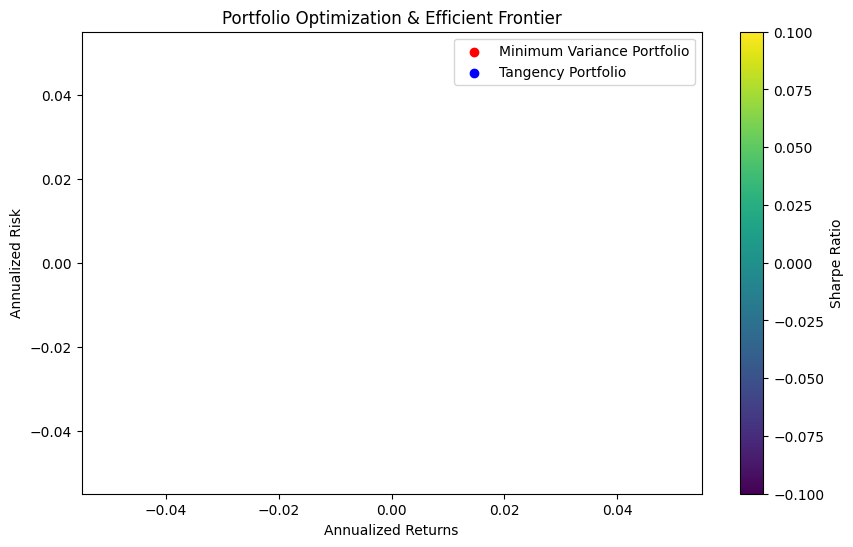


Minimum Variance Portfolio Asset Allocation:
               Asset Allocation  Invested Value
HDFCBANK.NS            0.027251    27251.308322
CAMS.NS                0.028674    28674.341203
KOTAKBANK.NS           0.000232      231.602974
TCS.NS                 0.017015    17015.013417
INFY.NS                0.013906    13905.611998
ITC.NS                 0.007399     7399.289935
PETRONET.NS            0.003993     3993.189632
AARTIIND.NS            0.011247    11247.297131
POWERGRID.NS           0.031412    31412.052853
IGL.NS                 0.010767    10767.168416
DIVISLAB.NS            0.017283    17282.968202
CONCOR.NS              0.023420    23420.343010
TARSONS.NS             0.012114    12113.940753
GODREJAGRO.NS          0.032374    32373.906024
SAREGAMA.NS            0.032063    32062.927310
MGL.NS                 0.008388     8387.864449
NAM-INDIA.NS           0.016565    16565.315091
ICICIBANK.NS           0.010023    10023.446923
MCX.NS                 0.009489     9489.1

In [24]:
# Plotting efficient frontier
risk_values = np.linspace(0, 0.5, 100)
returns = []
for risk in risk_values:
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: calc_portfolio_metrics(x, mean_ret, cov_mat, risk_free_return)[1] - risk})
    result = minimize(neg_sharpe_ratio, weights_init, args=(mean_ret, cov_mat, risk_free_return),
                      method='SLSQP', bounds=bounds, constraints=cons)
    returns.append(-result.fun)

plt.figure(figsize=(10, 6))
plt.scatter(returns, risk_values, c=np.array(returns) / np.array(risk_values), cmap='viridis')
plt.title('Portfolio Optimization & Efficient Frontier')
plt.xlabel('Annualized Returns')
plt.ylabel('Annualized Risk')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(min_var_metrics[0], min_var_metrics[1], marker='o', color='red', label='Minimum Variance Portfolio')
plt.scatter(max_sr_metrics[0], max_sr_metrics[1], marker='o', color='blue', label='Tangency Portfolio')
plt.legend()
plt.show()

# Asset allocation for minimum variance portfolio
min_var_portfolio_df = pd.DataFrame(min_var_weights, index=tickers, columns=['Asset Allocation'])
min_var_portfolio_df['Invested Value'] = min_var_portfolio_df['Asset Allocation'] * initial_investment
print("\nMinimum Variance Portfolio Asset Allocation:")
print(min_var_portfolio_df.head(25))

# Asset allocation for tangency portfolio
max_sr_portfolio_df = pd.DataFrame(max_sr_weights, index=tickers, columns=['Asset Allocation'])
max_sr_portfolio_df['Invested Value'] = max_sr_portfolio_df['Asset Allocation'] * initial_investment
print("\nTangency Portfolio Asset Allocation:")
print(max_sr_portfolio_df)